# Gaussian Process Regression for Ground Temperature Prediction

Here, the goal is to predict ground temperature at 2m depth using a GP built specifically for this target variable (other temperature depths also valid).

Main reason, is that we know that atmospheric temperature and altitude are near-linear predictors of ground temperature, so we can use kernels specific to these features. 


# What I've tried

- vanilla radial basis function kernel for all features
- instead of constant mean for all features use linear mean for temperature and altitude when estimating ground temperature
- use a categorical feature kernel for stratigraphy index
- when applying this to active layer thickness, scores went down quite a bit (0.9 down to 0.5)

## Things to try

- [ ] estimate temperatures at different depths for summer and winter instead of trying to estimate active layer thickness, use winter and summer temperatures (mean, 10th%, 90th%) etc.
- [ ] add [summer, winter, spring, autumn], [temperatures, precipitation] as features

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import glob
import os
import pathlib
import site
import sys
import warnings
import joblib
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from tqdm.dask import TqdmCallback as ProgressBarDask
from tqdm.notebook import tqdm as ProgressBar
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
from sklearn import model_selection
import torch

import cryogrid_pytools as cg
import pamir_mlpermafrost as pamir
from pamir_mlpermafrost.models import datasets as ml_data
from pamir_mlpermafrost.models import gp

# Loading data

In [3]:
data_X, data_y = ml_data.load_training_data(
    fname_data='../data/training/training_data-k1500-pamir_ns180-expX.parquet',
    sel='S180', target='ground_temp_2m')  #sel=((slice(None), slice(40000, None)),) , 

features = data_X.columns.tolist()

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data_X, data_y, test_size=0.2, random_state=72,
    stratify=data_X['surface_index']
)

# 1. Data Preprocessing - CRITICAL for GPs
scaler_X = pamir.models.datasets.StandardScaler_toTensor(skip_columns=[4])
scaler_y = pamir.models.datasets.StandardScaler_toTensor()

scaler_X.save('../data/training/scaler_X-StandardScaler_toTensor.joblib')
scaler_y.save('../data/training/scaler_y-StandardScaler_toTensor.joblib')

# Scale features
X_train_scaled_tensor = scaler_X.fit_transform(X_train)
X_test_scaled_tensor = scaler_X.transform(X_test)

# Scale target (reshape for sklearn)
y_train_scaled_tensor = scaler_y.fit_transform(y_train).ravel()
y_test_scaled_tensor = scaler_y.transform(y_test).ravel()

In [4]:
# features to dict with ints as keys
{i: features[i] for i in range(len(features))}

{0: 'altitude',
 1: 'slope_angle',
 2: 'aspect_cos',
 3: 'aspect_sin',
 4: 'surface_index',
 5: 'albedo',
 6: 'emissivity',
 7: 'snow_melt_doy',
 8: 'temperature',
 9: 'precipitation',
 10: 'temp2m_DJF_q05',
 11: 'temp2m_JJA_q05',
 12: 'temp2m_MAM_q05',
 13: 'temp2m_SON_q05',
 14: 'temp2m_DJF_q50',
 15: 'temp2m_JJA_q50',
 16: 'temp2m_MAM_q50',
 17: 'temp2m_SON_q50',
 18: 'temp2m_DJF_q95',
 19: 'temp2m_JJA_q95',
 20: 'temp2m_MAM_q95',
 21: 'temp2m_SON_q95',
 22: 'precip_DJF_q50',
 23: 'precip_JJA_q50',
 24: 'precip_MAM_q50',
 25: 'precip_SON_q50',
 26: 'precip_DJF_q95',
 27: 'precip_JJA_q95',
 28: 'precip_MAM_q95',
 29: 'precip_SON_q95'}

In [5]:
model = gp.ground_temp.GPMixedMeanCatIndex(
    X_train_scaled_tensor, 
    y_train_scaled_tensor, 
    gpytorch.likelihoods.GaussianLikelihood(), 
    linear_mean_idx=[0, 8],
    cat_idx=[4],
)

2025-07-30 17:45:17.995 | INFO     | ground_temp:__init__:45 - categories=tensor([1., 2., 3., 4.])


In [6]:
device = 'cpu'
model, losses = gp.train.train_mll(
    model.to(device), 
    X_train_scaled_tensor.to(device), 
    y_train_scaled_tensor.to(device), 
    tolerance=5e-3, 
    patience=5, 
    n_iters=500)

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:656.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
2025-07-30 17:45:19.045 | DEBUG    | train:train_mll:54 - Iter 1/500 - Loss: 2.121979
2025-07-30 17:45:19.229 | DEBUG    | train:train_mll:54 - Iter 2/500 - Loss: 2.055853
2025-07-30 17:45:19.414 | DEBUG    | train:train_mll:54 - Iter 3/500 - Loss: 1.985679
2025-07-30 17:45:19.606 | DEBUG    | train:train_mll:54 - Iter 4/500 - Loss: 1.925823
2025-07-30 17:45:19.791 | DEBUG    | train:train_mll:54 - Iter 5/500 - Loss: 1.872382
2025-07-30 17:45:19.976 | DEBUG    | train:train_mll:54 - Iter 6/500 - Loss: 1.827641
2025-07-30 17:

In [7]:
scores, y_pred, y_pred_std = gp.train.eval(model, X_train_scaled_tensor, y_train_scaled_tensor, scaler_y)

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Test Set Performance (Original Scale):
MSE: 0.3858
RMSE: 0.6212
MAE: 0.4342
R²: 0.9700
Predicted Std Dev: 1.4940


In [8]:
scores, y_pred, y_pred_std = gp.train.eval(model, X_test_scaled_tensor, y_test_scaled_tensor, scaler_y)

Test Set Performance (Original Scale):
MSE: 1.0720
RMSE: 1.0354
MAE: 0.6858
R²: 0.9131
Predicted Std Dev: 1.5116


# Inference 

In [66]:
fname_spatial = '../../pamir-CryoGrid/forcing/spatial_variables-710w365s750e400n-100m.zarr/'
fname_cryogrid = '../../pamir-CryoGrid/output/cluster_config-k1500-pamir_S180-exp1.zarr/'

da_cluster_labels = xr.open_zarr(fname_cryogrid, consolidated=True).cluster_labels.compute()

ds_spatial = xr.open_zarr(fname_spatial, consolidated=True).isel(x=slice(0, 2000), y=slice(-2000, None))
mask = (
    (ds_spatial.altitude > 3100)
    &
    (ds_spatial.surface_index > 0)
)

In [69]:
dataset = pamir.models.datasets.DatasetXarraySpatial(
    xarray_dataset=ds_spatial.chunk({'x': 300, 'y': 300}).persist(),
    chunk_processor=pamir.models.datasets.process_X_data,
    scaler=scaler_X,
)

In [70]:
out = gp.inference.predict(
    model, dataset, scaler_y
)

2025-07-30 18:04:45.152 | INFO     | <string>:predict:6 - Preparing datasets
2025-07-30 18:04:45.153 | INFO     | <string>:predict:10 - starting inference
python(88884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-07-30 18:04:54.523 | INFO     | <string>:predict:19 - Processed batch 1/49
2025-07-30 18:04:57.216 | INFO     | <string>:predict:19 - Processed batch 2/49
2025-07-30 18:04:59.394 | INFO     | <string>:predict:19 - Processed batch 3/49
2025-07-30 18:05:01.543 | INFO     | <string>:predict:19 - Processed batch 4/49
2025-07-30 18:05:03.605 | INFO     | <string>:predict:19 - Processed batch 5/49
2025-07-30 18:05:05.534 | INFO     | <string>:predict:19 - Processed batch 6/49
2025-07-30 18:05:06.355 | INFO     | <string>:predict:19 - Processed ba

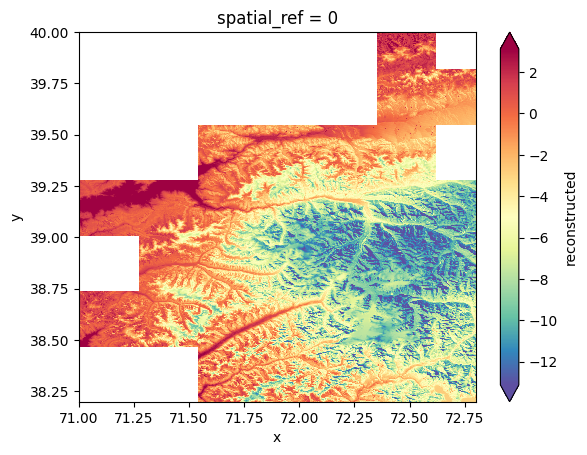

In [71]:
dataset.reconstruct_output(out[0]).pipe(lambda x: x * scaler_y.scale_[0] + scaler_y.mean_[0]).plot.imshow(robust=True, center=False, cmap='Spectral_r')

In [67]:
inference_X = ml_data.load_inference_data_from_zarr(ds_spatial, features=X_train.columns.tolist())
inference_X_scaled_tensor = scaler_X.transform(inference_X)

: 

In [ ]:
yhat_mu, yhat_sigma = gp.inference.predict(model, inference_X_scaled_tensor, scaler_y)

yhat_mu_da = yhat_mu.set_index(inference_X.index).iloc[:, 0].to_xarray()
yhat_sigma_da = pd.Series(yhat_sigma.numpy(), index=inference_X.index).to_xarray()

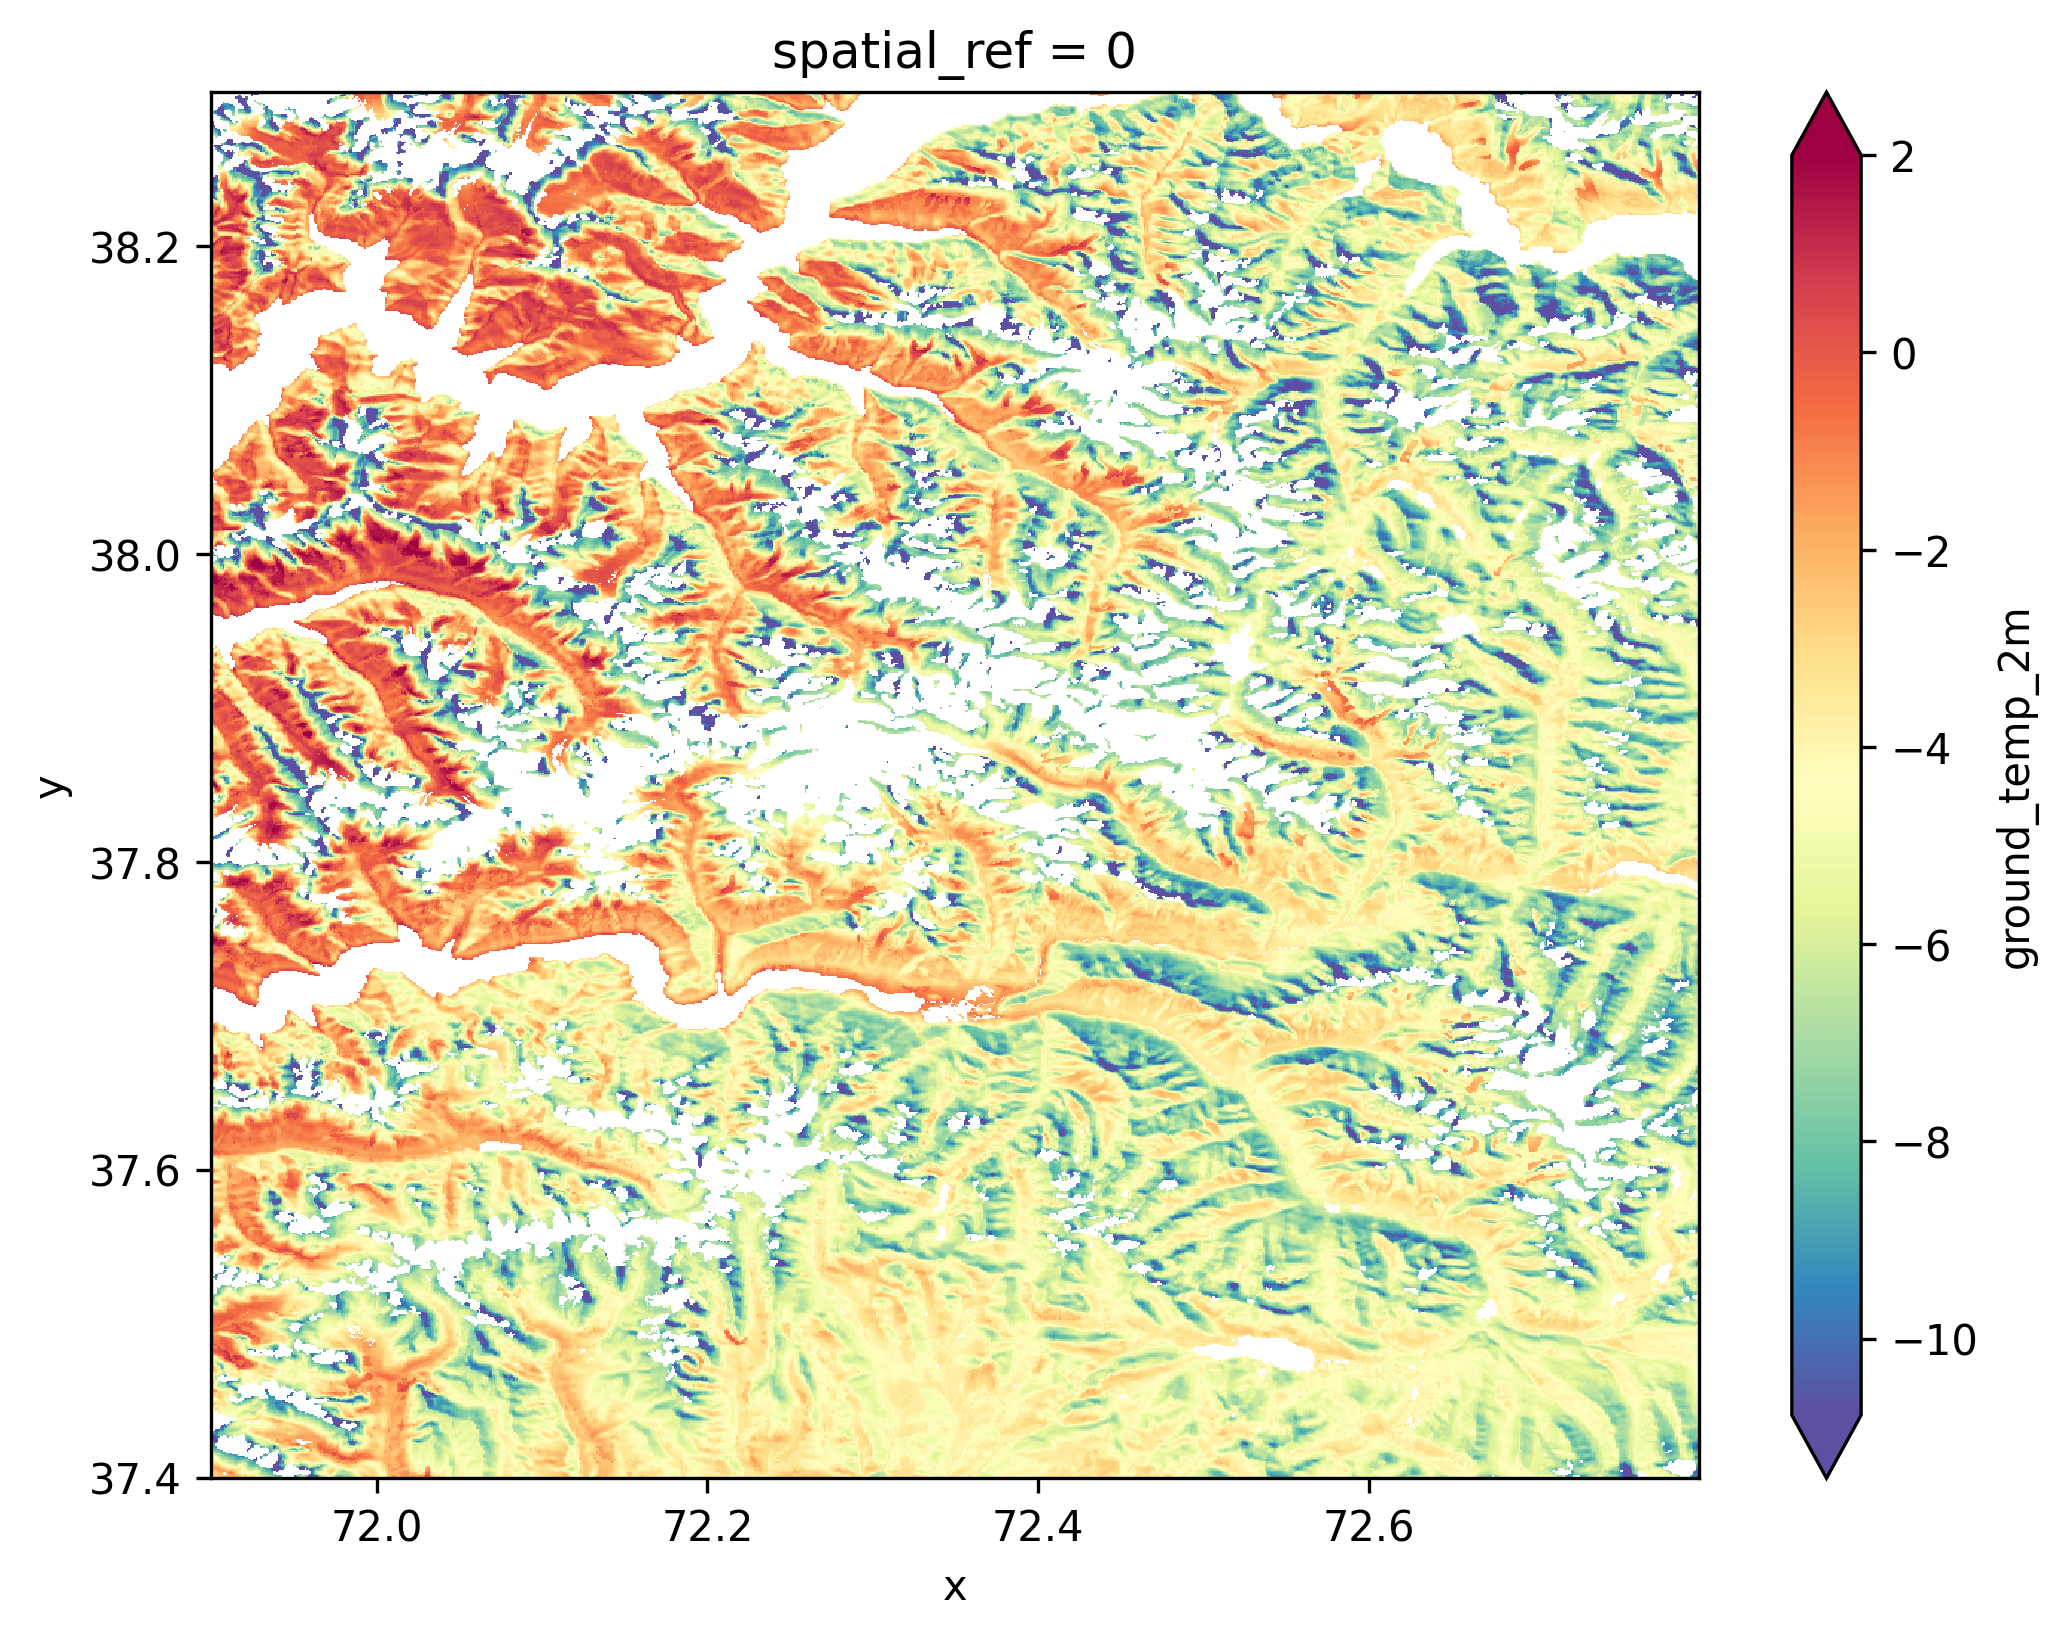

In [46]:
# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

img0 = (
    # yhat_sigma_da
    yhat_mu_da
    # .where(lambda x: x<0)
    .where(mask)
    .plot.imshow(
        ax=ax, 
        cmap='Spectral_r', 
        robust=True,
        vmax=2, center=False
    ))

In [47]:
y_da_unmapped = (
    data_y
    # .loc['N180']
    # .loc[40000:50000]
    .iloc[:, 0]
    .to_xarray()
    .assign_coords(tag=lambda x: x.tag - 10000)
    .rename(tag='index'))
y_da = cg.spatial_clusters.map_gridcells_to_clusters(
    y_da_unmapped,
    da_cluster_labels,    
).reindex_like(yhat_mu_da, method='nearest')

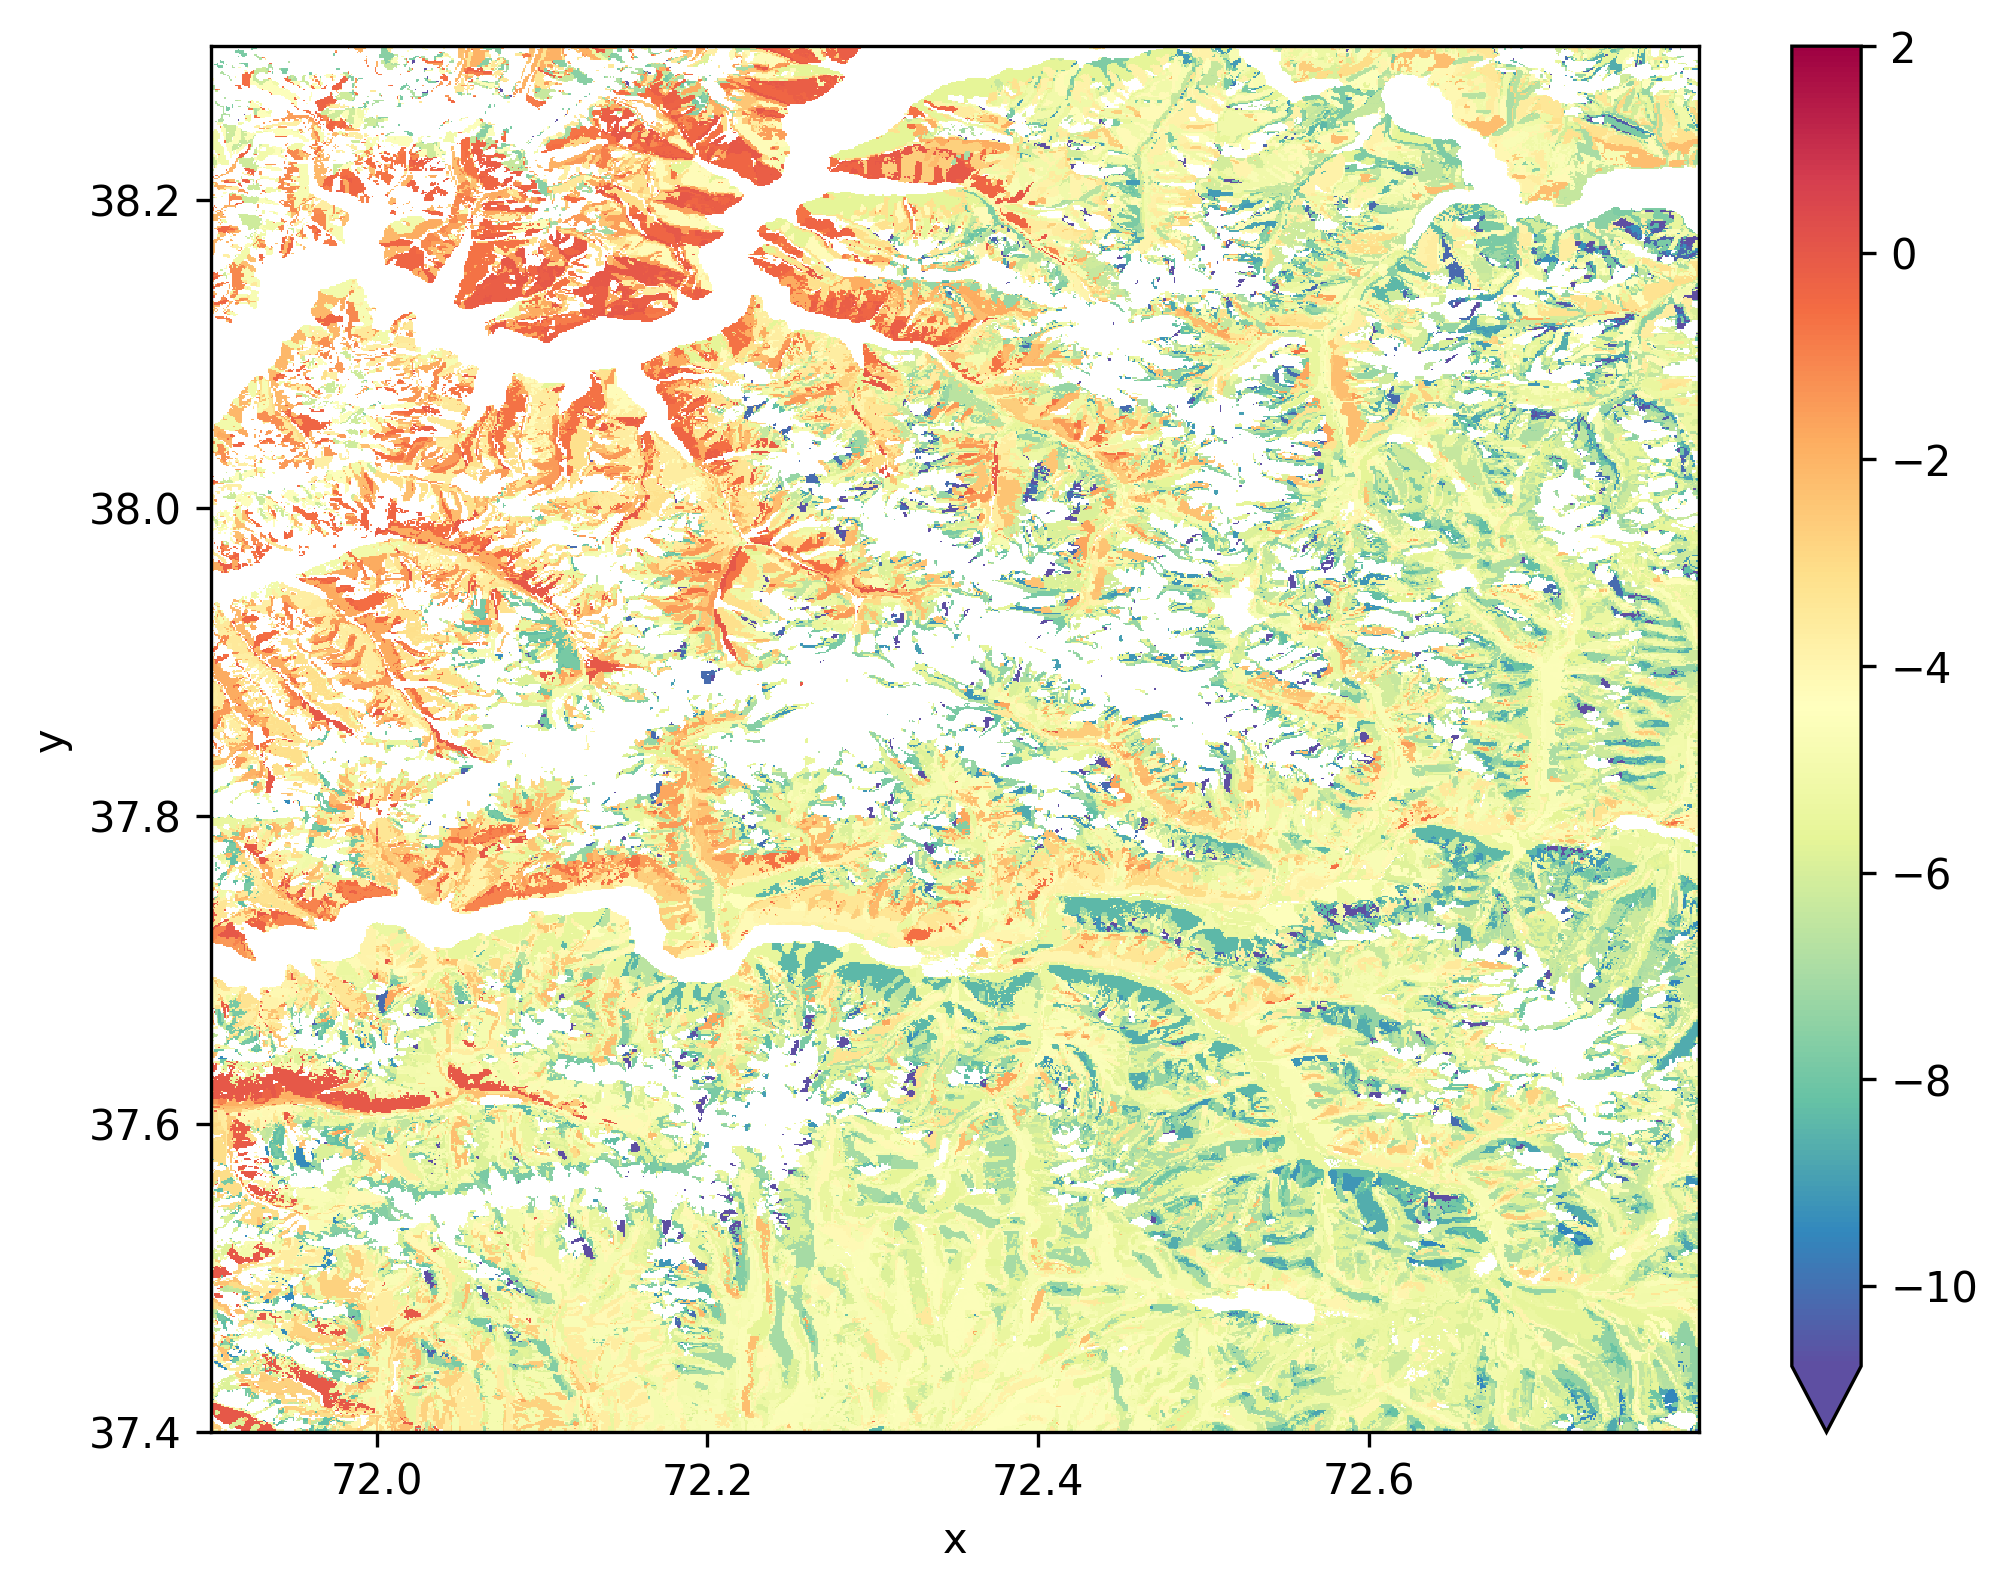

In [48]:
# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

img = (
    # yhat_sigma_da
    y_da
    # .where(mask)
    .where(lambda x: x<0)
    .plot.imshow(
        ax=ax, 
        cmap=img0.cmap, 
        vmin=img0.get_clim()[0], 
        vmax=img0.get_clim()[1]
    ))

# Buidling xarray data loader

In [6]:
fname_spatial = '../data/inference/inference_variables-710w365s750e400n-100m.zarr/'
ds = xr.open_zarr(fname_spatial, consolidated=True)

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/numcodecs/zarr3.py:145: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


In [11]:
dataset = pamir.models.datasets.DatasetXarraySpatial(
    ds.chunk({'x': 500, 'y': 500}), 
    pamir.models.datasets.process_X_data,
    scaler_X)

In [12]:
dataset[3]

tensor([[-2.1480, -0.5579, -0.9645,  ...,  1.3552,  3.0139,  2.2071],
        [-2.1815, -0.5431, -1.3156,  ...,  1.3521,  3.0098,  2.2040],
        [-2.1889, -0.2177, -1.4283,  ...,  1.3489,  3.0056,  2.2010],
        ...,
        [-1.7882,  0.4839, -1.4124,  ...,  0.0339,  1.8220,  1.4917],
        [-1.7823,  0.2245, -1.2751,  ...,  0.0336,  1.8207,  1.4908],
        [-1.8710,  1.5835, -0.7656,  ...,  0.0332,  1.8195,  1.4899]])

In [17]:
output = [dataset[i][:, 0] for i in range(len(dataset))]

In [18]:
a = dataset.reconstruct_output(output)

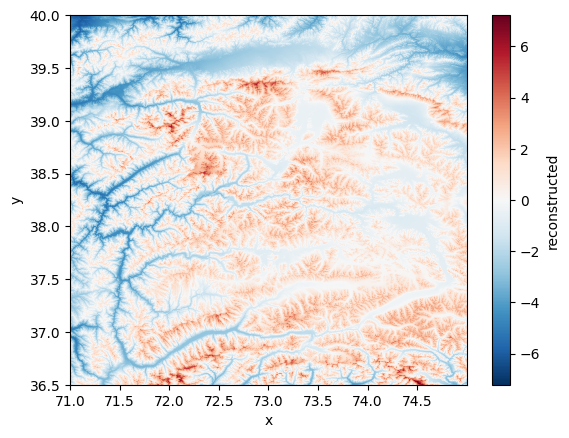

In [19]:
a.plot.imshow()